# Experiment 1

## To Do

## Setup

## Modules and settings

In [1]:
import numpy as np
import pandas as pd
import data_cleaning as dc
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.optimize as opt
import seaborn as sns
A, B, C, D = sns.color_palette('muted', 4)
sns.set_style('white')

## Directories

In [2]:
data_source = "./Raw/"
data_out = "./Clean/"
figure_out = "./Figures/weiji_talk/"

# Data Processing

In [3]:
def detect_error(row):
    is_error = np.nan
    if row.status == 'AFC2':
        if ((row.a_val > row.b_val) & (row.response == row.b)):
            is_error = 1
        elif ((row.a_val < row.b_val) & (row.response == row.a)):
            is_error = 1 
        elif row.a_val == row.b_val:
            is_error = .5
        else:
            is_error = 0
    else:
        is_error = int(row.gtv < row.posqual)
    return is_error

## Load data

In [38]:
subject_initials = ["AL", "AW", "EC", "FC", "GA", 
                    "HW", "JH", "JZ", "LH", "MH", "MS", "ZL"] #"SVO", "GVG"]
files = [data_source + s + ".csv" for s in subject_initials]
subjects = [dc.clean(f) for f in files]

for i in np.arange(len(subjects)):
    subjects[i] = subjects[i].loc[
        subjects[i].human == subjects[i].subject, :].reset_index(drop=True)
    subjects[i].loc[:, 'subject'] = str(i)
    subjects[i].loc[:, 'subject'] = subjects[i].loc[:, 'subject'].astype(int)
    
data = pd.concat(subjects).reset_index(drop=True)
data = data.reindex_axis(["subject","color","gi","mi","status",
                          "bp","wp","response","rt",'human','computer', 'time'], axis=1)

boards = pd.read_csv('experiment_boards_new.txt', sep='\t', 
                     names=['bp', 'wp', 'a', 'a_val', 'b', 'b_val', 'color', 'muinf'])
boards.loc[:, 'color'] = boards.loc[:, 'color'].map({'BLACK':0, 'WHITE':1})

objlists = ['objective_values_gen2.txt', 
            'objective_values_hvh.txt', 
            'objective_values_eye.txt']

obj = pd.concat([pd.read_csv(data_out + o, sep='\t', 
                            names=['bp', 'wp'] + list(range(36))) 
                for o in objlists]).reset_index(drop=True)

dupecols = ['subject', 'status', 'color', 'mi', 'bp', 'wp', 'response']
ai = data.loc[~data.status.isin(['AFC2', 'EVAL']), :]
afc = data.loc[data.status=='AFC2', :].drop_duplicates(subset=dupecols)
eva = data.loc[data.status=='EVAL', :].drop_duplicates(subset=dupecols)
data = pd.concat([ai, afc, eva]).reset_index(drop=True)

/Users/gianni/anaconda/lib/python3.4/site-packages/pandas/core/indexing.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [39]:
data.loc[:, 'gtv'] = np.nan
data.loc[:, 'posqual'] = np.nan
data.loc[:, 'error'] = np.nan
data.loc[:, 'a'] = np.nan
data.loc[:, 'b'] = np.nan

for i in data.index.values:
    r = int(data.loc[i, 'response'])
    bp = data.loc[i, 'bp']
    wp = data.loc[i, 'wp']
    c = data.loc[i, 'color']
    
    match = obj.loc[(obj.bp == bp) & (obj.wp == wp), :]
    bmatch = boards.loc[(boards.bp == bp) & (boards.wp == wp), :]
    
    if len(match) >= 1:
        gtv = match.loc[:, 35-r].values[0]
        gtv = gtv if ((gtv==0) | (np.abs(gtv) == 10000)) else 0
        gtv = gtv/10000
        pqual = np.nanmax(
            match.loc[:, list(range(35))].values[0]) if c == 0 else np.nanmin(
            match.loc[:, list(range(35))].values[0])
        pqual = pqual if ((pqual==0) | (np.abs(pqual) == 10000)) else 0
        pqual = pqual/10000
        data.loc[i, 'gtv'] = gtv if ((c == 0) | (gtv==0)) else -gtv
        data.loc[i, 'posqual'] = pqual if ((c == 0) | (pqual==0)) else -pqual
        
        if len(bmatch) >= 1:
            a = bmatch.loc[:, 'a'].values[0]
            b = bmatch.loc[:, 'b'].values[0]
            a_val = match.loc[:, 35-a].values[0]
            a_val = a_val if ((a_val==0) | (np.abs(a_val)==10000)) else 0
            a_val /= 10000
            
            b_val = match.loc[:, 35-b].values[0]
            b_val = b_val if ((b_val==0) | (np.abs(b_val)==10000)) else 0
            b_val /= 10000
            
            data.loc[i, 'a'] = a
            data.loc[i, 'b'] = b
            data.loc[i, 'a_val'] = a_val 
            data.loc[i, 'b_val'] = b_val
        data.loc[i, 'error'] = detect_error(data.loc[i, :])
        gtv = data.loc[i, 'gtv']
        pqual = data.loc[i, 'posqual']
        data.loc[i, 'gtv'] = gtv if ((c == 0) | (gtv==0)) else -gtv
        data.loc[i, 'posqual'] = pqual if ((c == 0) | (pqual==0)) else -pqual

# data.loc[data.status=='AFC2', 'error'] = 1 - data.loc[data.status=='AFC2', 'error']        

# data.loc[data.status=='AFC2', :].to_csv(data_out + 'afc2.csv')
# data.loc[data.status=='EVAL', ['subject', 'color', 'gi', 'mi', 'bp', 'wp', 'response', 'rt', 'human', 'computer', 'time', 'gtv']].to_csv(data_out + 'eval.csv')
# data.loc[~data.status.isin(['AFC2', 'EVAL']), :].to_csv(data_out + 'ai.csv')
data.head()


,subject,color,gi,mi,status,bp,wp,response,rt,human,computer,time,gtv,posqual,error,a,b,a_val,b_val
0,0,0,0,0,playing,000000000000000000000000000000000000,000000000000000000000000000000000000,13,2.582,0,0.00,1431443604600,0,0,0,NaN,NaN,NaN,NaN
1,0,0,0,2,playing,000000000000010000000000000000000000,000000000000000000000000000000000010,33,19.015,0,17.01,1431443634013,0,1,1,NaN,NaN,NaN,NaN
2,0,0,0,4,playing,000000000000010000000000000000000100,000000000000001000000000000000000010,23,4.040,0,17.01,1431443642253,0,0,0,NaN,NaN,NaN,NaN
3,0,0,0,6,win,000000000000010000000001000000000100,000000000000001000010000000000000010,3,1.421,0,17.01,1431443645162,1,1,0,NaN,NaN,NaN,NaN
4,0,1,1,1,playing,000010000000000000000000000000000000,000000000000000000000000000000000000,13,2.640,0,10.01,1431443657037,0,0,0,NaN,NaN,NaN,NaN


In [ ]:
data.status.unique()

In [ ]:
len(data.loc[data.status == 'AFC2', :])

In [ ]:
impcols = ['subject', 'color', 'gi', 'mi', 'status',
                        'bp', 'wp', 'response', 'rt', 'human', 
                        'computer', 'time', 'a', 'b', 'a_val', 'b_val']

data = pd.read_csv(data_out + 'afc2 2.csv', names=impcols)

for i in data.index.values:
    r = int(data.loc[i, 'response'])
    bp = data.loc[i, 'bp']
    wp = data.loc[i, 'wp']
    c = data.loc[i, 'color']
    
    match = obj.loc[(obj.bp == bp) & (obj.wp == wp), :]
    bmatch = boards.loc[(boards.bp == bp) & (boards.wp == wp), :]
    
    if len(match) >= 1:
        gtv = match.loc[:, 35-r].values[0]
        gtv = gtv if ((gtv==0) | (np.abs(gtv) == 10000)) else 0
        gtv = gtv/10000
        pqual = np.nanmax(
            match.loc[:, list(range(35))].values[0]) if c == 0 else np.nanmin(
            match.loc[:, list(range(35))].values[0])
        pqual = pqual if ((pqual==0) | (np.abs(pqual) == 10000)) else 0
        pqual = pqual/10000
        data.loc[i, 'gtv'] = gtv if ((c == 0) | (gtv==0)) else -gtv
        data.loc[i, 'posqual'] = pqual if ((c == 0) | (pqual==0)) else -pqual
        
        if len(bmatch) >= 1:
            a = bmatch.loc[:, 'a'].values[0]
            b = bmatch.loc[:, 'b'].values[0]
            a_val = match.loc[:, 35-a].values[0]
            a_val = a_val if ((a_val==0) | (np.abs(a_val)==10000)) else 0
            a_val /= 10000
            
            b_val = match.loc[:, 35-b].values[0]
            b_val = b_val if ((b_val==0) | (np.abs(b_val)==10000)) else 0
            b_val /= 10000
            
            data.loc[i, 'a'] = a
            data.loc[i, 'b'] = b
            data.loc[i, 'a_val'] = a_val
            data.loc[i, 'b_val'] = b_val
        data.loc[i, 'error'] = detect_error(data.loc[i, :])
        
        av = data.loc[i, 'a_val']
        bv = data.loc[i, 'b_val']
        data.loc[i, 'a_val'] =  av if ((c == 0) | (gtv==0)) else -av
        data.loc[i, 'b_val'] = bv if ((c == 0) | (gtv==0)) else -bv

data.loc[data.status=='AFC2', 'error'] = 1 - data.loc[data.status=='AFC2', 'error']

data.loc[:, ['subject', 'color', 'gi', 'mi', 'status',
                        'bp', 'wp', 'response', 'rt', 'human', 
                        'computer', 'time', 'a', 'b', 
             'a_val', 'b_val']].reset_index(drop=True).to_csv(data_out + 'afc2_new.csv', 
                                                              header=False)
data

In [27]:
data.loc[data.status=='AFC2']


,subject,color,gi,mi,status,bp,wp,response,rt,human,computer,time,gtv,posqual,error,a,b,a_val,b_val
2020,0,0,13,0,AFC2,000000000000100000001011010000001000,001010000001010000000100100000000000,31,49.943,0,0,1431445587474,-1,0,0.5,5,31,-1,-1
2021,0,1,14,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,26.906,0,0,1431445615452,1,1,0.0,4,5,-1,0
2022,0,1,15,0,AFC2,000000000001100000001100000000001100,000100000000011000000011000000000000,31,43.817,0,0,1431445660333,0,1,1.0,31,30,0,-1
2023,0,1,16,0,AFC2,001011000010010000000100000000010000,000100000001100000000010000001100000,27,9.517,0,0,1431445671118,1,1,0.0,27,19,-1,0
2024,0,0,17,0,AFC2,000000000001000100000010000000000100,000101000000010000000001000000000000,6,31.764,0,0,1431445703903,0,0,0.5,6,4,0,0
2025,0,0,18,0,AFC2,001000000000001000000001100000010000,000010000000110000000010000000001000,15,11.302,0,0,1431445716463,0,0,0.5,15,7,0,0
2026,0,1,19,0,AFC2,000000000000010000001011100000101100,000110000000101000000100010000010000,5,2.428,0,0,1431445719960,1,1,0.5,5,1,-1,-1
2027,0,1,20,0,AFC2,000011000000010000000000000000000000,000100000000000000000100000000000000,12,21.976,0,0,1431445742991,0,0,0.5,12,22,0,0
2028,0,1,21,0,AFC2,000000000000011000000101000000000100,000100000000100100010000000000000000,11,11.369,0,0,1431445755424,1,1,0.0,11,5,-1,1
2029,0,1,22,0,AFC2,011000000001000000001100000000100000,000000000000000010000010000001011000,24,22.637,0,0,1431445779121,1,1,0.5,24,4,-1,-1


## Analyses

In [23]:
sns.set_palette('deep')
sns.set_style('white')
sns.set_context('poster')
B, G, R, P = sns.color_palette('deep', 4)
%matplotlib inline

### AI

#### Select Data

In [29]:
# data.loc[data.status=='AFC2', 'color'] = (data.loc[data.status=='AFC2', 'color'] + 1) % 2

probe = np.array([np.array(list(data.loc[i, 'bp'])).astype(int).sum() - 
          np.array(list(data.loc[i, 'wp'])).astype(int).sum() 
         for i in data.index.values])


data.loc[probe != data.color, :]

,subject,color,gi,mi,status,bp,wp,response,rt,human,computer,time,gtv,posqual,error,a,b,a_val,b_val


In [161]:
d = data.loc[~data.status.isin(['AFC2', 'EVAL']), :].reset_index(drop=True)
for dex in d.loc[(d.mi==0)&(d.gi==0), :].index.values:
    d.loc[dex, 'computer'] = d.loc[dex+1, 'computer']

In [33]:
# wins n draws
dex = d.loc[d.mi.isin([0,1]), :].index.values
ends = d.loc[dex[1:]-1, :]
ends.loc[ends.status=='playing', 'status'] = 'loss'
ends.reset_index(drop=True).loc[:, ['subject', 'computer', 'gi', 'color', 'status']].to_csv(data_out + "game_ends_for_elo.csv", index=False, header=False)
ends
ends.loc[:, 'wld'] = ends.loc[:, 'status'].map({'loss':0, 'draw':.5, 'win':1})
def compasint(i):
    return int(float(i) - .01)
# (ends.computer.unique().astype(float) - .01).astype(int)
ends.loc[:, 'computer'] = ends.loc[:, 'computer'].map(compasint)
ends.loc[:, 'tier'] = ends.loc[:, 'computer'] // 5

In [34]:
games_per_computer = pd.DataFrame(index=ends.subject.unique(), columns=np.arange(30))
games_per_computer.loc[:, :] = 0

wins_per_computer = pd.DataFrame(index=ends.subject.unique(), columns=np.arange(30))
wins_per_computer.loc[:, :] = 0

draws_per_computer = pd.DataFrame(index=ends.subject.unique(), columns=np.arange(30))
draws_per_computer.loc[:, :] = 0


endsnodraw = ends.loc[ends.status!='draw', :]
endsdraw = ends.loc[ends.status=='draw', :]

for s in endsnodraw.index.values:
    wins_per_computer.loc[endsnodraw.loc[s, 'subject'], endsnodraw.loc[s, 'computer']] += endsnodraw.loc[s, 'wld']
    
for s in ends.index.values:
    games_per_computer.loc[ends.loc[s, 'subject'], ends.loc[s, 'computer']] += 1
    
for s in endsdraw.index.values:
    draws_per_computer.loc[endsdraw.loc[s, 'subject'], endsdraw.loc[s, 'computer']] += endsdraw.loc[s, 'wld']*2
    
games_per_computer.to_csv(data_out + 'games_x_computer.csv', header=False, index=False)
wins_per_computer.to_csv(data_out + 'wins_x_computer.csv', header=False, index=False)
draws_per_computer.to_csv(data_out + 'draws_x_computer.csv', header=False, index=False)

/Users/gianni/anaconda/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


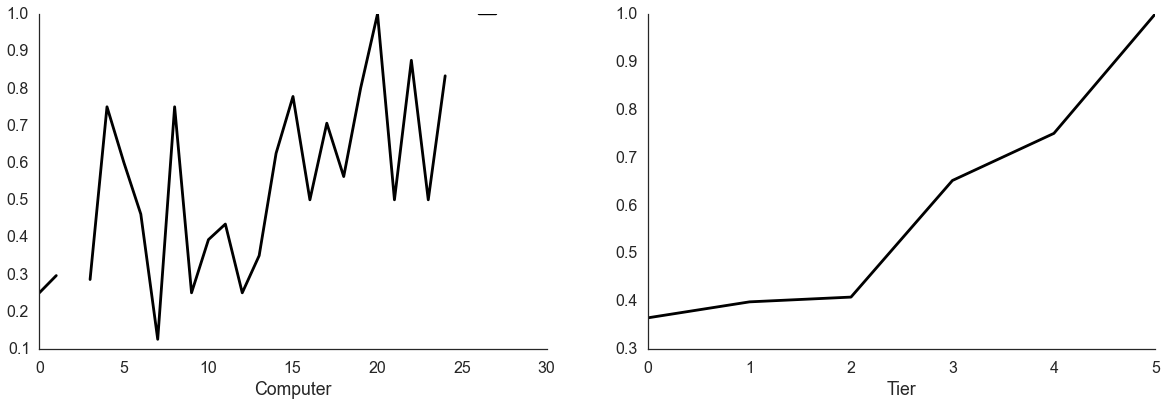

In [35]:
f, axes = plt.subplots(1, 2, figsize=(20,6), squeeze=False)

dex = np.arange(30)
rate_means = []
rate_errs = []

for _d in dex:
    _e = ends.loc[(ends.computer==_d), 'wld'].values
#     print(_d, _e.size, np.mean(_e))
    m = np.mean(_e)
    if _e.size > 0:
        rate_means.append(m)
#         rate_errs[_d] = np.std(_e)
    else:
        rate_means.append(np.nan)
    
axes[0,0].plot(dex, rate_means, color='black')
axes[0,0].set_xlabel('Computer')

dex = np.arange(6)
tier_means = []

for _d in dex:
    _e = ends.loc[(ends.tier==_d), 'wld'].values
    m = np.mean(_e)
    if _e.size > 0:
        tier_means.append(m)
    else:
        tier_means.append(np.nan)
        
axes[0,1].plot(dex, tier_means, color='black')
axes[0,1].set_xlabel('Tier')
sns.despine()
f.savefig(figure_out + 'psychometric_curve_ai_all_subs.png', format='png')

# resample means

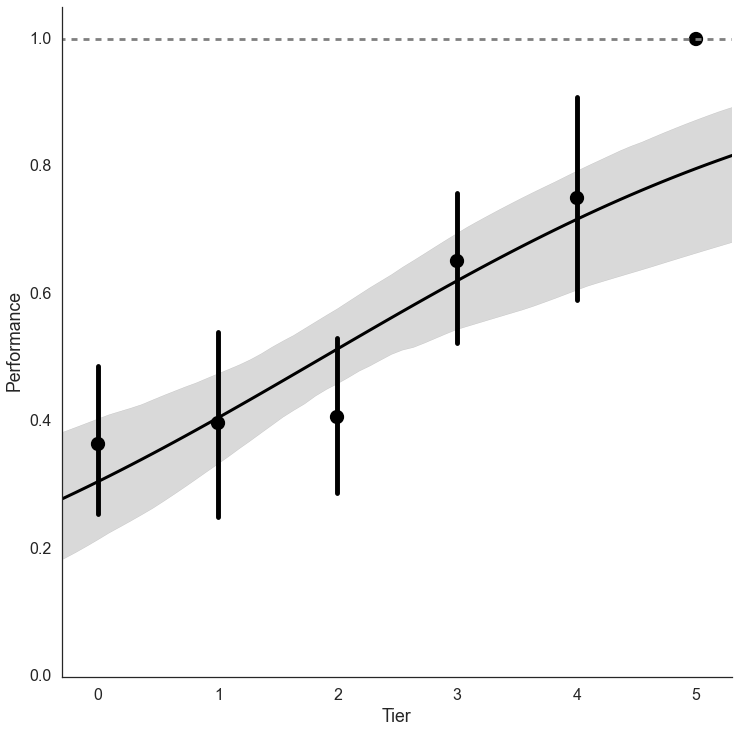

In [39]:
f, axes = plt.subplots(1,1, figsize=(12,12), squeeze=False)
axes[0, 0].plot([-1, 6], [1, 1], '--', color='grey')
sns.regplot('tier', 'wld', data=ends, x_estimator=np.mean, fit_reg=True,
            logistic=True, n_boot=len(ends), color='black', ax=axes[0,0], 
            scatter_kws={'s':150, 'linewidth':2}, line_kws={'linewidth':3})
axes[0,0].set_ylim([0, 1.05])
axes[0, 0].set_ylabel('Performance')
axes[0,0].set_xlim([-.3, 5.3])
axes[0,0].set_xlabel('Tier')
sns.despine()
f.savefig(figure_out + 'psychometric_curve.png', format='png')

In [62]:
# d = ai.loc[:, ['subject', 'color', 'bp', 'wp', 'response', 'computer', 'gi', 'mi', 'time']]
# fig, axes = plt.subplots(nrows=len(d.subject.unique()), ncols=1, figsize=(10,15), squeeze=False)

# for s in ai.subject.unique():
#     curax = axes[s, 0]
#     p = d.loc[(d.subject==s)&((d.mi==d.color)|(d.mi==d.color)), :]
#     curax.plot(p.time.values - p.time.values[0], p.computer.values//5, label='bracket')
#     curax.plot(p.time.values - p.time.values[0], p.computer.values/5, label='opponent')
#     curax.legend()
    
# # fig.savefig(figure_out + 'opponent_path.png', format='png')

In [64]:
stdr[1]

(1.2260073524504593, 1.5081366675227743)

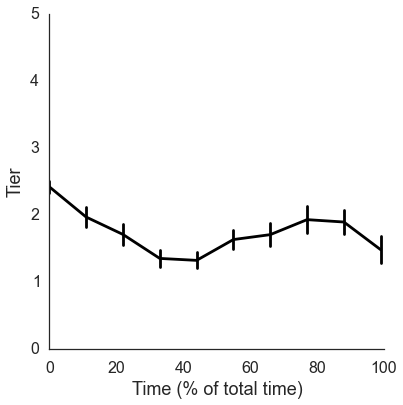

In [164]:
# what bas wants: at each time, average value of current opponent
d.loc[:, 'adjtime'] = np.concatenate([
        d.loc[d.subject==s, 'time'].values - 
        d.loc[d.subject==s, 'time'].values[0] for s in d.subject.unique()])

# time_bins1 = np.linspace(0, d.loc[:, 'adjtime'].max(), 101)
time_bins2 = np.linspace(0, d.loc[:, 'adjtime'].max(), 11)

_dd = d.sort('adjtime').reset_index(drop=True)

x2 = []
y2 = []
err2 = []

for t in range(len(time_bins2))[:-1]:
    interval = time_bins2[t:t+2]
    _ddd = _dd.loc[(_dd.adjtime >= interval[0]) & (_dd.adjtime < interval[1]), :]
    x2.append(t)
    y2.append((_ddd.loc[:, 'computer']//5).mean())
    meanr, varr, stdr = sts.bayes_mvs(_ddd.loc[:, 'computer']//5)
    err2.append(meanr[1])
# print(err2)
x2 = np.array(x2)
y2 = np.array(y2)

fig, axes = plt.subplots(1, 1, squeeze=False, figsize=(6,6))
ax = axes[0,0]
# ax.plot(x1, y1, color=P)
ax.plot(np.array(x2)*11, y2, color='black')
for er in range(len(err2)):
    ax.plot([11*x2[er], 11*x2[er]], [err2[er][0], err2[er][1]], color='black')
ax.set_xlabel('Time (% of total time)', fontsize=18)
ax.set_ylim([0,5])
ax.set_ylabel('Tier', fontsize=18)
sns.despine()
fig.savefig(figure_out + 'averaged_opponent.png', format='png')

## AFC

### Helper Functions

In [19]:
def plt_agrees(df, ptype="agree", 
               ax=plt.gca(), fig=plt.gcf()):
    
    if ptype=="agree":
        val = (df.values.sum() - len(df))/df.values.size
        ax.set_title('Mean Agreement: ' + str(val)[:6])
    elif ptype=="dist":
        val = (df.values.sum() - .5*len(df)) / df.values.size
        ax.set_title('Mean distance From Random : ' + str(val)[:6])
    
    sns.heatmap(data=df, vmin=df.values.min(), vmax=df.values.max(), 
            annot=True, cbar=False, ax=ax, square=True);
        
    return fig, axes, val;

### Summary Table Of Agreements

In [20]:
dd = data.loc[data.status=='AFC2', :]

for n in range(len(subjects)):
    dd.loc[:, n] = np.nan

for s1 in dd.subject.unique():
    
    for s2 in dd.subject.unique():
        
        for i in dd.loc[dd.subject == s1, :].index.values:
            bp = dd.loc[i, 'bp']
            wp = dd.loc[i, 'wp']
            r = dd.loc[i, 'response']
            condition = (dd.subject == s2) & (dd.bp == bp) & (dd.wp == wp)
           
            if len(dd.loc[condition, :]) == 1:
                if dd.loc[condition, 'response'].values[0] == r:
                    dd.loc[i, s2] = 1
                else:
                    dd.loc[i, s2] = 0

afc_by_subject = [dd.loc[dd.subject==s, :].reset_index(drop=True) 
                  for s in dd.subject.unique()]

ca_helper = pd.DataFrame(index=range(len(afc_by_subject)), 
                         columns=range(len(afc_by_subject)))

for _s1 in range(len(afc_by_subject)):
    s1 = afc_by_subject[_s1]
    for _s2 in range(len(afc_by_subject)):
        s2 = afc_by_subject[_s2]
        _ag = (s1.loc[:, _s1] == s1.loc[:, _s2]).astype(int)
        ca_helper.loc[_s1, _s2] = _ag.sum()/len(_ag)
                                   
ca_helper = ca_helper.astype(float)
ca_dist = np.abs(ca_helper - .5)

good_guys = ca_dist.loc[ca_dist.mean() >= ca_dist.values.mean(), :].index.values
good_guys_ag = ca_helper.loc[good_guys, good_guys]
good_guys_dist = ca_dist.loc[good_guys, good_guys]
okay_guys = ca_dist.loc[ca_dist.mean() >= ca_dist.values.mean()*.75, :].index.values
okay_ag = ca_helper.loc[okay_guys, okay_guys]
okay_d = ca_dist.loc[okay_guys, okay_guys]

/Users/gianni/anaconda/lib/python3.4/site-packages/pandas/core/indexing.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/gianni/anaconda/lib/python3.4/site-packages/pandas/core/indexing.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


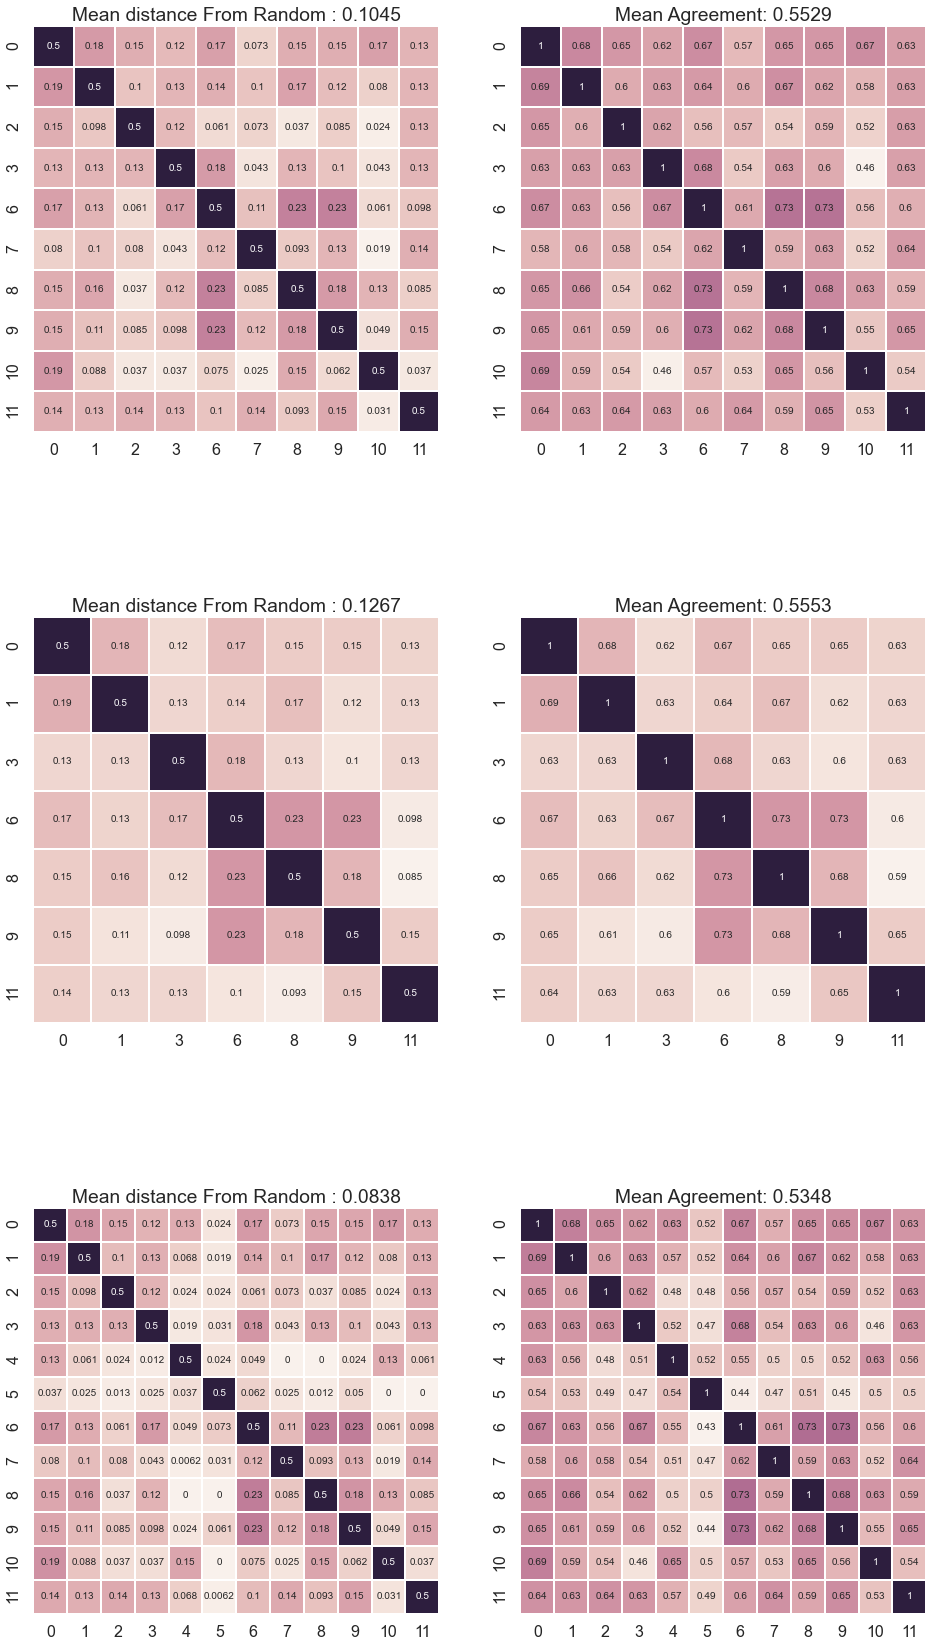

In [35]:
f, axes = plt.subplots(3, 2, figsize=(16, 30), squeeze=False)

plt_agrees(okay_d, ptype="dist", ax=axes[0,0]);
plt_agrees(okay_ag, ptype="agree", ax=axes[0,1]);
plt_agrees(good_guys_dist, ptype="dist", ax=axes[1,0]);
plt_agrees(good_guys_ag, ptype="agree", ax=axes[1,1]);
plt_agrees(ca_helper, ptype="agree", ax=axes[2,1]);
plt_agrees(ca_dist, ptype="dist", ax=axes[2,0]);
f.savefig(figure_out + 'agreement_histograms.png', format='png')

In [45]:
data.loc[data.status=='AFC2', 'error'] = 1 - data.loc[data.status=='AFC2', 'error']
data.loc[:, 'error'] = 1 - data.loc[:, 'error']

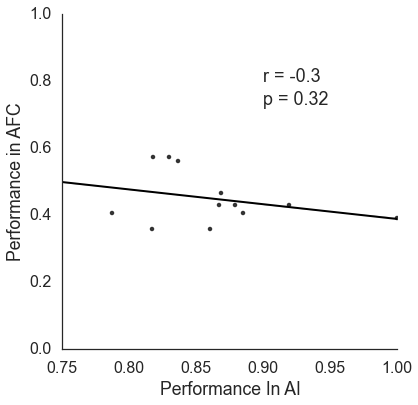

In [159]:
sns.set_style('white')
afc_perf = np.array([data.loc[(data.subject==s)&(data.status=='AFC2')&(data.error!=.5), 'error'].mean() 
                     for s in data.subject.unique()])
ai_perf = np.array([data.loc[(data.subject==s)&(~data.status.isin(['AFC2','EVAL'])), 'error'].mean() 
                    for s in data.subject.unique()])
ai_ELO = np.array([224, 138, -45, 0, 29, -9, -5,57, -330, 115, -72, 164])


f, axes = plt.subplots(1, 1, figsize=(6, 6), squeeze=False)
ax = axes[0,0]
ax.set_xlim([.75, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('Performance In AI')
ax.set_ylabel('Performance in AFC')
sns.regplot(ai_perf, afc_perf, color='black', ax=ax, ci=False, line_kws={'linewidth':2})

# ax = axes[0, 1]
# ax.set_ylim([-400, 400])
# ax.set_xlim([.5, 1])
# ax.set_xlabel('Performance In AI')
# ax.set_ylabel('ELO')
# sns.regplot(ai_perf, ai_ELO, color='black', ax=ax, ci=False)

sns.despine()
# print(sts.pearsonr(ai_ELO, ai_perf))
ax.text(x=.9, y=.8, s="r = " + str(sts.pearsonr(ai_perf, afc_perf)[0])[:4], fontsize=18)
ax.text(x=.9, y=.73, s="p = " + str(sts.pearsonr(ai_perf, afc_perf)[1])[:4], fontsize=18)
# print(sts.pearsonr(ai_ELO, afc_perf))
f.savefig(figure_out + 'performance_afc_v_ai.png', format='png')

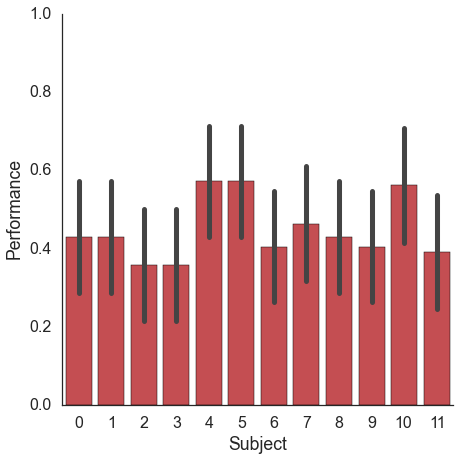

In [157]:
sns.set_style('white')
f, axes = plt.subplots(1, 1, figsize=(7, 7), squeeze=False)
ax = axes[0, 0]
sns.barplot('subject', 'error', data=data.loc[(data.status=='AFC2')&(data.error != .5), :], ax=ax, color=R)
ax.set_ylim([0,1])
ax.set_xlabel('Subject')
ax.set_ylabel('Performance')

# ax = axes[0, 1]
# ax.set_ylim([-400, 400])
# ax.set_xlim([.5, 1])
# ax.set_xlabel('Performance In AI')
# ax.set_ylabel('ELO')
# m, b, r, p, s = sts.linregress(ai_perf, ai_ELO)
# ax.text(x=.8, y=300, s="r = " + str(r)[:4], fontsize=18)
# ax.text(x=.8, y=250, s="p = " + str(p)[:4], fontsize=18)
# sns.regplot(ai_perf, ai_ELO, color='black', ax=ax, ci=False, line_kws={'linewidth':2})

sns.despine()
f.savefig(figure_out + 'performance_by_subject.png', format='png')

In [189]:
arf = data.loc[(data.status=='AFC2')&(data.error != .5), :]
arf.loc[:, 'wholeboard'] = arf.loc[:, 'bp'] + arf.loc[:, 'wp']

perf = np.array([np.nanmean(arf.loc[arf.wholeboard == b, 'error']) 
                 for b in arf.wholeboard.unique()])
np.sort(perf)
easy = arf.loc[arf.wholeboard == arf.wholeboard.unique()[perf.argmax()], :]
hard = arf.loc[arf.wholeboard == arf.wholeboard.unique()[perf.argmin()], :]
hard

/Users/gianni/anaconda/lib/python3.4/site-packages/pandas/core/indexing.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/gianni/anaconda/lib/python3.4/site-packages/pandas/core/indexing.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,subject,color,gi,mi,status,bp,wp,response,rt,human,computer,time,gtv,posqual,error,a,b,a_val,b_val,wholeboard
2021,0,1,14,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,26.906,0,0,1431445615452,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2124,1,1,49,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,4.654,0,0,1431367448368,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2252,2,1,106,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,3.443,0,0,1429816325667,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2339,3,1,103,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,3.832,0,0,1431103379765,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2412,4,1,96,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,3.353,0,0,1431358953259,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2439,5,1,43,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,1.423,0,0,1431385949447,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2565,6,1,73,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,8.241,0,0,1430431796531,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2649,7,1,86,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,14.271,0,0,1431098300472,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2740,8,1,74,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,15.903,0,0,1431039312433,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2803,9,1,67,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,5.302,0,0,1431115548520,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...


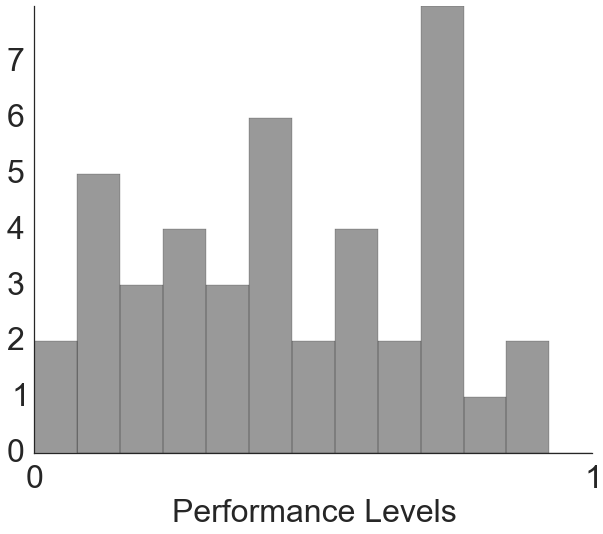

In [207]:
f, ax = plt.subplots(1,1,figsize=(10,8))
sns.distplot(perf, norm_hist=False, kde=False, bins=np.linspace(0, 1, 14), color='black')
ax.set_xticks([0, 1])
ax.set_xticklabels([0, 1], fontsize=32)
ax.set_yticklabels(list(range(8)), fontsize=32)
ax.set_ylabel('')
ax.set_xlabel('Performance Levels', fontsize=32)
sns.despine()
f.savefig(figure_out + 'performance level histogram.png', format='png')

In [139]:
hard

,subject,color,gi,mi,status,bp,wp,response,rt,human,computer,time,gtv,posqual,error,a,b,a_val,b_val,wholeboard
2021,0,1,14,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,26.906,0,0,1431445615452,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2124,1,1,49,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,4.654,0,0,1431367448368,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2252,2,1,106,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,3.443,0,0,1429816325667,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2339,3,1,103,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,3.832,0,0,1431103379765,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2412,4,1,96,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,3.353,0,0,1431358953259,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2439,5,1,43,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,1.423,0,0,1431385949447,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2565,6,1,73,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,8.241,0,0,1430431796531,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2649,7,1,86,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,14.271,0,0,1431098300472,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2740,8,1,74,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,15.903,0,0,1431039312433,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...
2803,9,1,67,0,AFC2,000000000000011000000100000000011001,000000100000100000001010000000100000,4,5.302,0,0,1431115548520,-1,-1,0,4,5,-1,0,0000000000000110000001000000000110010000001000...


## Evaluation

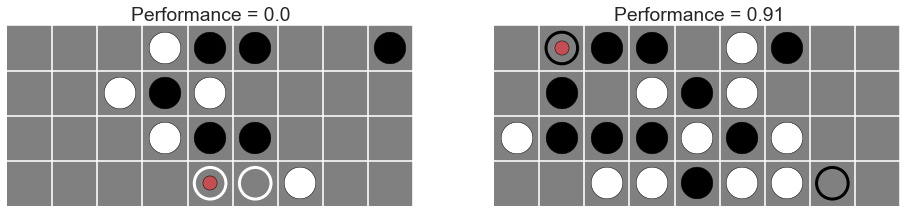

In [138]:
def expandposition(string):
    _q = np.array(list(string)).astype(int)
    return np.where(_q==1)[0]

def plotpos(frame, axe):
    bp = expandposition(frame.loc[frame.index.values[0], 'bp'])
    wp = expandposition(frame.loc[frame.index.values[0], 'wp'])
    a = frame.loc[frame.index.values[0], 'a']
    b = frame.loc[frame.index.values[0], 'b']
    c = frame.loc[frame.index.values[0], 'color']
    if c==0:
        correct = a if a > b else b
    elif c==1:
        correct = a if a < b else b
    
    bpx = bp % 9
    bpy = bp // 9
    wpx = wp %9
    wpy = wp //9
    ax = a%9
    ay = a//9
    bx = b%9
    by = b//9
    cx = correct % 9
    cy = correct // 9
    
    axe.scatter(bpx, bpy, c='black', s= 1000)
    axe.scatter(wpx, wpy, c='white', s=1000)
    axe.scatter([ax, bx], [ay, by], s=1000, 
                facecolor='none', edgecolor='white' if c else 'black', linewidth=3)
    axe.scatter(cx, cy, s=200, c=R)
    axe.set_axis_bgcolor('grey')
    axe.set_xticks(np.arange(10)+.5)
    axe.set_yticks(np.arange(4) + .5)
    axe.set_xticklabels([])
    axe.set_yticklabels([])
    axe.set_ylim([-.5, 3.5])
    axe.set_xlim([-.5, 8.5])
    axe.set_aspect(1)
    return frame.error.mean()

sns.set_style('darkgrid')
f, axes = plt.subplots(1, 2, figsize=(16, 12), squeeze=False)

title1 = plotpos(hard, axe=axes[0, 0])
axes[0, 0].set_title('Performance = ' + str(title1)[:4])
title2 = plotpos(easy, axe=axes[0, 1])
axes[0, 1].set_title('Performance = ' + str(title2)[:4])
sns.despine()
f.savefig(figure_out + 'easy_hard_examples_with_markers.png', format='png')

In [132]:
evapreds = pd.read_csv(data_out + 'eval_pred.csv')
evapreds.columns = evapreds.loc[0, :]
evapreds = evapreds.loc[1:, :].reset_index(drop=True).astype(float)

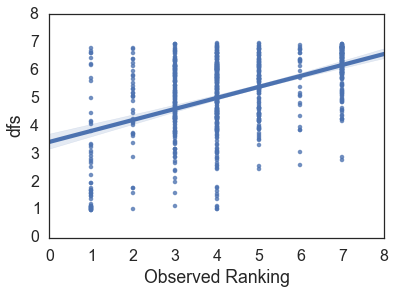

In [133]:
sns.regplot('Observed Ranking', 'dfs', data=evapreds)

## Junk

In [19]:
for n in range(len(subjects)):
    eva.loc[:, n] = np.nan

for s1 in eva.subject.unique():
    
    for s2 in eva.subject.unique():
        
        for i in eva.loc[eva.subject == s1, :].index.values:
            bp = eva.loc[i, 'bp']
            wp = eva.loc[i, 'wp']
            r = eva.loc[i, 'response']
            condition = (eva.subject == s2) & (eva.bp == bp) & (eva.wp == wp)
           
            if len(eva.loc[condition, :]) == 1:
                eva.loc[i, s2] = eva.loc[condition, 'response'].values[0]
            elif len(eva.loc[condition, :]) > 1:
                eva.loc[i, s2] = eva.loc[condition, 'response'].values.mean()

eva.loc[:, 'mean_response'] = eva.loc[:, range(12)].mean(axis=1)
eva.loc[:, 'mean_dist_mean'] = np.abs((eva.loc[:, range(12)] - eva.loc[:, 'mean_response'])).mean(axis=1)

In [ ]:
is_won = np.zeros(len(boards))

for i in boards.index.values:
    a = boards.loc[i,:].a_val
    b = boards.loc[i,:].b_val
    
    if a == 1 or b == 1:
        is_won[i] = 1
    elif a == 0  or b == 0:
        is_won[i] = 0
    else:
        is_won[i] = -1
    
    if (a + b) == 2:
        choice_type[i] = 0
    elif (a + b) == 1:
        choice_type[i] = 1
    elif (a + b) == -2:
        choice_type[i] = 5
    elif (a + b) == -1:
        choice_type[i] = 4
    else:
        if a != b:
            choice_type[i] = 2
        else:
            choice_type[i] = 3
            
boards.loc[:, "choice_type"] = choice_type
boards.loc[:, 'is_won'] = is_won
boards_prime = boards.copy().sort('muinf', ascending=False).reset_index(drop=True)
eval_boards = boards_prime.copy()
afc_boards = boards_prime.copy()
eval_boards = pd.concat([eval_boards.loc[eval_boards.is_won == i][:26] for i in eval_boards.is_won.unique()])
eval_boards.reset_index(drop=True, inplace=True)
afc_boards = pd.concat([afc_boards.loc[afc_boards.choice_type == i][:13] for i in afc_boards.choice_type.unique()])
afc_boards.reset_index(drop=True, inplace=True)

In [6]:
# boards.loc[:, 'newaval'] = np.nan
# boards.loc[:, 'newbval'] = np.nan
# for b in boards.index.unique():
#     bp = boards.loc[b, 'bp']
#     wp = boards.loc[b, 'wp']
#     _a = boards.loc[b, 'a'].astype(int)
#     _b = boards.loc[b, 'b'].astype(int)
    
# #     print(obj.loc[(obj.loc[:, 'bp'] == bp) & (obj.loc[:, 'wp'] == wp), _b].values)
#     boards.loc[b, 'newaval'] = obj.loc[(obj.loc[:, 'bp'] == bp) & (obj.loc[:, 'wp'] == wp), _a].values[0]

#     boards.loc[b, 'newbval'] = obj.loc[(obj.loc[:, 'bp'] == bp) & (obj.loc[:, 'wp'] == wp), _b].values[0]

In [12]:
# extras = afc.loc[pd.isnull(afc.a), 'bp'].unique()
# missings = afc_boards.loc[~afc_boards.bp.isin(afc.bp.unique()), 'bp'].unique()
# evaxtras = eva.loc[~eva.bp.isin(eval_boards.bp.unique()), 'bp'].unique()
# evassings = eval_boards.loc[~eval_boards.bp.isin(eva.bp.unique()), 'bp'].unique()

# ai.loc[ai.subject == ai.subject.unique()[-1], :].to_csv(data_out + "bas_ai.csv", header=False)
# afc.to_csv(data_out + "afc2.csv", header=False) #.loc[afc.subject == afc.subject.unique()[-1], :]
# eva.to_csv(data_out + "eval.csv", header=False)
# boards.loc[0, 'bp'][22];
# oo.loc[:, 22];
# oo = obj.loc[(obj.bp == boards.loc[8, 'bp']) & (obj.wp == boards.loc[8, 'wp']), :]
# oo.wp.values[0][22];
# boards.loc[8, :];
# ai = data.loc[~data.status.isin(['EVAL', 'AFC2']), :].reset_index(drop=True)
# afc = data.loc[data.status.isin(['AFC2']), :].reset_index(drop=True)
# eva = data.loc[data.status.isin(['EVAL']), :].reset_index(drop=True)
# afc[0].agrees.sum()/len(afc[0])
# afc[1].agrees.sum()/len(afc[1])

In [ ]:
# afc.loc[:, 'a'] = np.nan
# afc.loc[:, 'b'] = np.nan

# for b in boards.index.values:
    
#     bp = boards.loc[b, 'bp']
#     wp = boards.loc[b, 'wp']
#     _a = boards.loc[b, 'a']
#     _aval = boards.loc[b, 'a_val']
#     _b = boards.loc[b, 'b']
#     _bval = boards.loc[b, 'b_val']
    
#     afc.loc[(afc.bp == bp) & (afc.wp == wp), 'a'] = _a
#     afc.loc[(afc.bp == bp) & (afc.wp == wp), 'b'] = _b
#     afc.loc[(afc.bp == bp) & (afc.wp == wp), 'aval'] = _aval
#     afc.loc[(afc.bp == bp) & (afc.wp == wp), 'bval'] = _bval
    

In [8]:
# print((ca_helper.values.sum() - len(ca_helper))/ca_helper.values.size)
# print((ca_dist.values.sum() - .5*len(ca_dist))/ca_dist.values.size)

In [22]:
# d = afc.loc[:, ['subject', 'color', 'bp', 'wp', 'response', 'rt', 'a', 'b', 'aval', 'bval']]
# d.loc[:, 'chose_a'] = (d.loc[:, 'response'] == d.loc[:, 'a']).astype(int)
# # made incorrect choice
# # chose a and aval < bval
# _c1a = (d.aval < d.bval)&(d.loc[:, 'chose_a'] == 1)
# _c1b = (d.aval > d.bval)&(d.loc[:, 'chose_a'] == 0)
# # chose b and bval < aval

# # does color matter here?

# d.loc[:, 'error'] = 0
# d.loc[_c1a | _c1b, 'error'] = 1

# byboard = []
# for b in d.bp.unique():
#     if len(d.loc[d.bp == b, 'wp'].unique()) <= 1:
#         byboard.append(d.loc[d.bp == b, :])
#     else:
#         for w in d.loc[d.bp == b, 'wp'].unique():
#             byboard.append(d.loc[(d.bp == b)&(d.wp == w), :])
            
# de = d.loc[d.aval != d.bval, :].reset_index(drop=True)
# byboarde = []
# for b in de.bp.unique():
#     if len(de.loc[de.bp==b, 'wp'].unique()) <= 1:
#         byboarde.append(de.loc[de.bp==b, :])
#     else:
#         for w in de.loc[de.bp==b, 'wp'].unique():
#             byboarde.append(de.loc[(de.bp==b)&(de.wp==w), :])

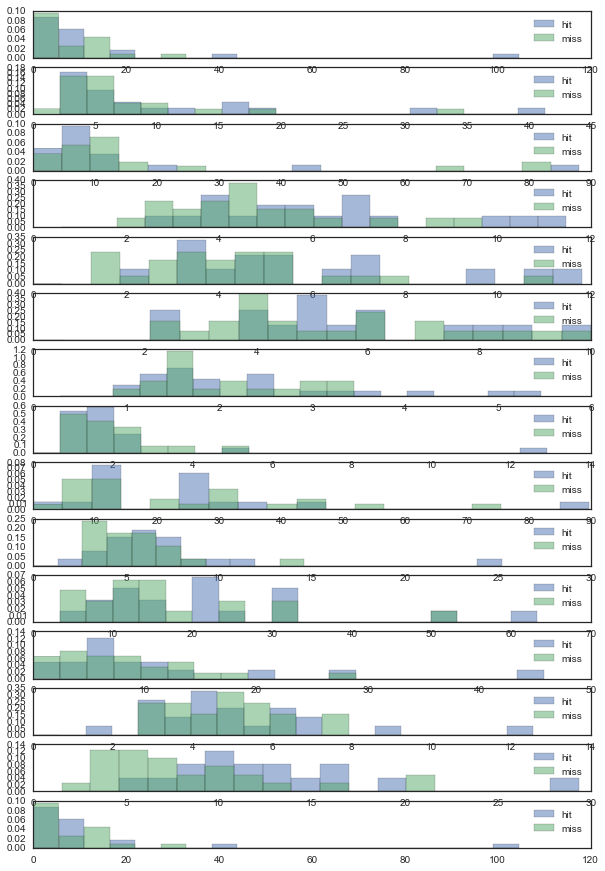

In [23]:
# fig, axes = plt.subplots(nrows=len(de.subject.unique()), ncols=1, figsize=(10,15), squeeze=False)
# for _s in de.subject.unique():
#     h0 = de.loc[(de.loc[:, 'subject']==_s) & (de.loc[:, 'error']==0), 'rt'].values
#     h1 = de.loc[(de.loc[:, 'subject']==_s) & (de.loc[:, 'error']==1), 'rt'].values
#     curax = axes[_s,0]
#     curax.hist(h0, normed=True, alpha=.5, label='hit', bins=np.linspace(0, h0.max(), 20))
#     curax.hist(h1, normed=True, alpha=.5, label='miss', bins=np.linspace(0, h0.max(), 20))
#     curax.legend()
# fig.savefig(figure_out + 'rt_error.png', format='png')
# x = np.array([b.loc[:, 'rt'].mean() for b in byboarde])
# y = np.array([b.loc[:, 'error'].mean() for b in byboarde])
# plt.scatter(x, y)
# plt.hist(x)
# de = d.loc[np.abs(d.aval - d.bval) > 0, :]
# print(de.error.sum()/len(de))
# sns.factorplot('subject', 'error', kind='bar', data=de);
# byboard = []
# for b in d.bp.unique():
#     if len(d.loc[d.bp==b, 'wp'].unique()) <= 1:
#         byboard.append(d.loc[d.bp==b, :])
#     else:
#         for w in d.loc[d.bp==b, 'wp'].unique():
#             byboard.append(d.loc[(d.bp==b)&(d.wp==w), :])
# wha = [b for b in byboard if len(b) != 12]
# print([len(i) for i in wha])
# # extra 
# # 7(1)(602 603) 
# # 5(1)(445 446)
# # 10(2)(889 890; 876 877)
# # 1(1)(138 139) 
# # 11(1)(951 952)
# # missing
# # 1(1)(000000000001110000000001000000101000)
# # 11(1)(000000000000011000010010000010000000)
# # 5(2)(000001001000010100000001000000001001, 001100100001110000011100010000011010)
# # 7(1)(000000000000010100000001000000010100)
# # 3(1)(001100100001110000011100010000011010)
# fraction_a = np.array([b.loc[:, 'chose_a'].sum() / len(b) for b in byboard])
# agreement = np.array([a if a >= .5 else 1-a for a in fraction_a])
# fraction_right = np.array([(1 - b.loc[:, 'error']).sum() / len(b) for b in byboard])
# plt.hist(fraction_right, bins=np.arange(13)/12)
# ca_helper = pd.DataFrame(index=d.loc[d.subject==0].reset_index(drop=True).index.values, columns=d.subject.unique())

# for s in d.subject.unique():
    
#     ca_helper.loc[:, s] = d.loc[d.subject==s, 'chose_a'].values
    
# cross_agreement = pd.DataFrame(index=d.subject.unique(), columns=d.subject.unique()).astype(float)

# for s0 in ca_helper.columns.values:
#     for s1 in ca_helper.columns.values:
#         cross_agreement.loc[s0, s1] = (ca_helper.loc[:, s0] == ca_helper.loc[:, s1]).sum() / len(ca_helper)
        
# ca = cross_agreement
# _probe = np.abs(ca - .5)
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10), squeeze=False)
# sns.heatmap(_probe, vmin=0, vmax=.5, annot=True, ax=axes[0,0])
# plt.gca().set_aspect(1)
# dist_from_rand = np.abs(ca - .5)

# dfrs = dist_from_rand.sum()
# dfrs.sort()
# dfin = dfrs.index.values[::-1]

# ca = ca.loc[dfin[:5], dfin[:5]]
# ca.values.mean()
# ca.to_csv('cross_subject_agreement_afc.csv', sep=',', header=False, index=False)
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10), squeeze=False)
# axes[0,0].set_aspect(1)
# sns.heatmap(ca.values, vmin=.3, vmax=.75, ax=axes[0,0],
#             annot=True, xticklabels=ca.columns.values, yticklabels=ca.index.values);
# fig.savefig(figure_out + 'most_agreeable_five.png', format='png')
# plt.hist(ca.values.reshape([ca.values.size]), alpha=.7, color=B, label='data')
# plt.hist(sa.loc[dfin[:5], dfin[:5]].values.reshape([sa.loc[dfin[:5], dfin[:5]].values.size]), alpha=.7, color=D, label='berno random')
# plt.gca().legend()
# plt.show()
# sim = pd.DataFrame(data=np.array([np.random.binomial(1, .5, len(ca_helper)) for i in np.arange(12)]).T, index=ca_helper.index.values, columns=ca_helper.columns.values)
# sim_agreement = cross_agreement.copy()
# for s0 in sim.columns.values:
#     for s1 in sim.columns.values:
        
#         _ag = (sim.loc[:, s0] == sim.loc[:, s1]).sum() / len(sim)
#         sim_agreement.loc[s0, s1] = _ag #if _ag >= .5 else (1 - _ag)
        
# sa = sim_agreement.astype(float)
# sa
# sns.heatmap(sa.values, vmin=.3, vmax=.7, annot=True)